In [1]:
import tensorflow as tf 
import numpy as np 
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
import tensorflow_model_optimization as tfmot
#disable_eager_execution()
enable_eager_execution()

In [4]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [5]:
x_train = np.expand_dims(x_train, axis=-1)

# [optional]: we may need 3 channel (instead of 1)
x_train = np.repeat(x_train, 3, axis=-1)

# it's always better to normalize 
x_train = x_train.astype('float32')

x_train = tf.keras.applications.resnet.preprocess_input(x_train)

In [6]:
x_train.shape

(60000, 28, 28, 3)

In [7]:
# resize the input shape , i.e. old shape: 28, new shape: 32
x_train = tf.image.resize(x_train, [32,32]) # if we want to resize 

# one hot 
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

print(x_train.shape, y_train.shape)

(60000, 32, 32, 3) (60000, 10)


In [8]:
input = tf.keras.Input(shape=(32,32,3))
efnet = tf.keras.applications.ResNet50(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(efnet.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax', use_bias=True)(gap)

# bind all

In [9]:
model_ = tf.keras.Model(efnet.input, output)

In [10]:
fp_model = tf.keras.Model(efnet.input, output)

In [11]:
fp_model.compile(
          optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
          loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [12]:
history = fp_model.fit(x_train, y_train, batch_size=128, epochs=5, verbose = 2)

Epoch 1/5
469/469 - 78s - loss: 0.5941 - accuracy: 0.8253
Epoch 2/5
469/469 - 61s - loss: 0.0791 - accuracy: 0.9770
Epoch 3/5
469/469 - 61s - loss: 0.0345 - accuracy: 0.9895
Epoch 4/5
469/469 - 60s - loss: 0.0192 - accuracy: 0.9939
Epoch 5/5
469/469 - 61s - loss: 0.0126 - accuracy: 0.9959


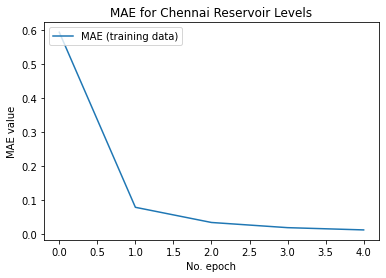

In [13]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [14]:
fp_model.save('../../weights/resnet_mnist_fp.h5')

In [10]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [11]:
q_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
q_history = q_model.fit(x_train, y_train, batch_size=128, epochs=5, verbose = 2)

Epoch 1/5
469/469 - 309s - loss: 0.6288 - accuracy: 0.8049
Epoch 2/5
469/469 - 284s - loss: 0.0897 - accuracy: 0.9734
Epoch 3/5
469/469 - 284s - loss: 0.0394 - accuracy: 0.9878
Epoch 4/5
469/469 - 284s - loss: 0.0214 - accuracy: 0.9931
Epoch 5/5
469/469 - 284s - loss: 0.0134 - accuracy: 0.9955


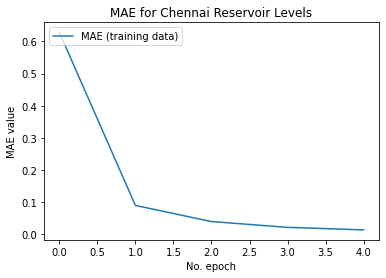

In [13]:
plt.plot(q_history.history['loss'], label='MAE (training data)')
plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
q_model.save('../../weights/resnet_mnist_q.h5')